# Predict TripAdvisor Rating

prepared by: Khudyakova Alexandra (Худякова Александра)

- link to kaggle competition: https://www.kaggle.com/c/sf-dst-restaurant-rating/
- link to my [this] notebook on kaggle: https://www.kaggle.com/alexandrakhudyakova/sf-tripadvisor-rating-v2-7-khudyakova/

# import

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from itertools import combinations
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

nan = np.nan

# for splitting our dataset:
from sklearn.model_selection import train_test_split

In [3]:
# to make results reproducable
RANDOM_SEED = 42

In [4]:
!pip freeze > requirements.txt

# DATA

In [6]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [10]:
# for correct feature processing we consolidate train and test features in one dataset
df_train['sample'] = 1 # marking train
df_test['sample'] = 0 # marking test
df_test['Rating'] = 0 # we do not have Rating in test, since we need to predict it, so we fill it with zeros

data = df_test.append(df_train, sort=False).reset_index(drop=True) # consolidating in one dataset

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Initial Features:
* City 
* Cuisine Style
* Ranking: Ranking among other restaurants in the city
* Price Range
* Number of Reviews
* Reviews: 2 last reviews with dates
* URL_TA: restaurant's page on 'www.tripadvisor.com' 
* ID_TA: restaurant's ID on TripAdvisor
* Rating

In [12]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
18820,id_1774,Paris,"['French', 'European', 'Vegetarian Friendly', ...",1775.0,$$ - $$$,278.0,"[['Relaxed Dinner', 'Nice food'], ['11/01/2017...",/Restaurant_Review-g187147-d1035273-Reviews-Le...,d1035273,1,4.0
4331,id_4331,Hamburg,NaN,2022.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187331-d12338007-Reviews-H...,d12338007,0,0.0
4809,id_4809,Madrid,['Spanish'],8626.0,$$ - $$$,62.0,[['Rip off deluxe !!!! not for foregners ....'...,/Restaurant_Review-g187514-d2182340-Reviews-Ce...,d2182340,0,0.0
4686,id_4686,London,"['Indian', 'Vegetarian Friendly', 'Vegan Optio...",2979.0,$$ - $$$,220.0,"[['Cosy & affordable', 'Very good Indian Food'...",/Restaurant_Review-g186338-d1389705-Reviews-Re...,d1389705,0,0.0
28167,id_2996,Madrid,NaN,2998.0,NaN,43.0,"[['Really fast service', 'Basic local bar/rest...",/Restaurant_Review-g187514-d991719-Reviews-Asa...,d991719,1,4.0


In [13]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Most features require preprocessing

## Functions

In [14]:
# updating cuisine column to lists
def cuisine_to_list(cell):
    if type(cell) == str:
        cell = cell[1:-1].replace("'", "").split(', ')
        return cell
    
    
# labelling price ranges
def price_to_label(cell):
    if type(cell) == str:
        if cell == '$':
            return 1
        if cell == '$$ - $$$':
            return 2
        if cell == '$$$$':

            return 3
        
# updating reviews column to tuples
def format_reviews(cell):
    if type(cell) == str:
        if cell == '[[], []]':
            cell = nan  # we will look at NaN values further
        else:
            cell = eval(cell.replace("], [", ", ").replace("[[",'').replace("]]",''))
        return cell

    
# filling in NAN cells in number of reviews
def fill_number_review(x):
    if (pd.isna(x['Number of Reviews'])) and (pd.notna(x['Reviews'])):
        if len(x['Reviews']) == 2: ## i.e. only one text and one date
            return 1
    if (pd.isna(x['Number of Reviews'])) and (pd.isna(x['Reviews'])):
        return 0
    return x['Number of Reviews']


# defining other city
def other_city(cell):
    if cell not in top_15_cities:
        cell = 'Other'
    return cell


# using reviews column to create columns with texts and dates
def review_text(cell):
    if cell == 'Not Available':
        return cell
    if len(cell) == 2:
        return cell[0]
    if len(cell) == 4:
        return list(cell[:2])

    
def review_date1(cell):
    if cell == 'Not Available' or len(cell) == 2:
        return pd.to_datetime(np.nan)
    if len(cell) == 4:
        return pd.to_datetime(cell[2]).date()
    
    
def review_date2(cell):
    if cell == 'Not Available':
        return pd.to_datetime(np.nan)
    if len(cell) == 2:
        return pd.to_datetime(cell[1]).date()
    if len(cell) == 4:
        return pd.to_datetime(cell[3]).date()

    
# labelling time periods
def date_diff_label(days):
    if days <= 7:
        return 1
    if 7 < days <= 30:
        return 2
    if 30 < days <= 180:
        return 3
    if 180 < days <= 365:
            return 4
    if days > 365:
        return 5

    
# defining top cuisine styles
def top_cuisine(cell):
    new_cuisine_list = []
    if cell == 'Other':
        new_cuisine_list.append(cell)
    for cuisine in cell:
        if cuisine  in top_15_cuisines:
            new_cuisine_list.append(cuisine)
    return new_cuisine_list    


# labelling cuisine styles (for new feature)
def vegetarian_friendly(cell):
    if 'Vegetarian Friendly' in cell:
        return 1
    else:
        return 0
    
def european(cell):
    if 'European' in cell:
        return 1
    else:
        return 0

def other(cell):
    if 'Other' in cell:
        return 1
    else:
        return 0
    
def mediterranean(cell):
    if 'Mediterranean' in cell:
        return 1
    else:
        return 0

def italian(cell):
    if 'Italian' in cell:
        return 1
    else:
        return 0

def vegan_options(cell):
    if 'Vegan Options' in cell:
        return 1
    else:
        return 0

def gluten_free(cell):
    if 'Gluten Free Options' in cell:
        return 1
    else:
        return 0

def bar(cell):
    if 'Bar' in cell:
        return 1
    else:
        return 0

def french(cell):
    if 'French' in cell:
        return 1
    else:
        return 0

def asian(cell):
    if 'Asian' in cell:
        return 1
    else:
        return 0

def pizza(cell):
    if 'Pizza' in cell:
        return 1
    else:
        return 0

def spanish(cell):
    if 'Spanish' in cell:
        return 1
    else:
        return 0

def pub(cell):
    if 'Pub' in cell:
        return 1
    else:
        return 0

def cafe(cell):
    if 'Cafe' in cell:
        return 1
    else:
        return 0

def fast_food(cell):
    if 'Fast Food' in cell:
        return 1
    else:
        return 0

    
# creating legend list for our pie chat
def pie_legend(x):
    if x == 1:
        return 'week or less'
    if x == 2:
        return '1 week - 1 month'
    if x == 3:
        return '1 month - 6 months'
    if x == 4:
        return '6 months - 1 year'
    if x == 5:
        return 'more than a year'

# Cleaning and Prepping Data


## Updating the format

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Cuisine Style to list

In [16]:
# make cuisine styles => lists
type(data['Cuisine Style'][1])

str

In [17]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: cuisine_to_list(x))

### Price Range to labels

In [18]:
data['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [19]:
data['Price Range'] = data['Price Range'].apply(lambda x: price_to_label(x))

### Reviews to tuples
Column with reviews contains the text of 1-2 latest reviews (if available) and their dates. However the cells are in string format. We will update the format to tuple to make reviews' details callable.

Reviews column can contain: a) 2 reviews; b) 1 review; c) blank cell; d) NaN cell

In [20]:
print('A: ', data['Reviews'][333])
print('B: ', data['Reviews'][74])
print('C: ', data['Reviews'][44246]) 
print('D: ', data['Reviews'][9608])

A:  [['Juicy tender beef steaks!', 'A Real steak joint & they have Wagyu!'], ['12/01/2017', '11/05/2017']]
B:  [["Nova' Doba"], ['01/26/2017']]
C:  [[], []]
D:  nan


In [21]:
data['Reviews'] = data['Reviews'].apply(lambda x: format_reviews(x))

## Filling in NAN cells


In [22]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews               8114
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

In [23]:
data.isna().sum() / len(data)

Restaurant_id        0.00000
City                 0.00000
Cuisine Style        0.23180
Ranking              0.00000
Price Range          0.34722
Number of Reviews    0.06400
Reviews              0.16228
URL_TA               0.00000
ID_TA                0.00000
sample               0.00000
Rating               0.00000
dtype: float64

There are 4 columns with NAN values: Cuisine Style, Price Range, Number of Reviews, Reviews. We will try to fill in these NAN cells (not drop). But first, we'll create new feature - No reviews.

In [24]:
data['No Reviews'] = data['Number of Reviews'].isna()

### NAN: Cuisine Style
If there is no Cuisine Style mentioned, let us replace it with 'Other'

In [25]:
data['Cuisine Style'].fillna('Other', inplace=True)

### NAN: Price Range
If there is no Price Range mentioned, let us replace it with the mode.

In [26]:
# but first, let us check whether price range mode depends on the city
data.groupby('City')['Price Range'].agg(lambda x: x.value_counts().index[0])

City
Amsterdam     2.0
Athens        2.0
Barcelona     2.0
Berlin        2.0
Bratislava    2.0
Brussels      2.0
Budapest      2.0
Copenhagen    2.0
Dublin        2.0
Edinburgh     2.0
Geneva        2.0
Hamburg       2.0
Helsinki      2.0
Krakow        2.0
Lisbon        2.0
Ljubljana     2.0
London        2.0
Luxembourg    2.0
Lyon          2.0
Madrid        2.0
Milan         2.0
Munich        2.0
Oporto        2.0
Oslo          2.0
Paris         2.0
Prague        2.0
Rome          2.0
Stockholm     2.0
Vienna        2.0
Warsaw        2.0
Zurich        2.0
Name: Price Range, dtype: float64

In [27]:
# all cities' modes are 2 (average price tag), so all missing values can be filled in by 2
data['Price Range'].fillna(2, inplace=True)

### NAN: Number of Reviews
When there is one review in Reviews column, we can assume there is at least one available review and fill in Number of Reviews column with 1, since TripAdvisor does not allow you rate a restaurant without a review. 

We also can assume that if there are NAN values in both Reviews and Number of Reviews, there has been no reviews for the period taken, so Number of Reviews can be filled in with 0. 

When there are two reviews available, we will fill NAN with median.

We can also check that there is no conflict with non-NAN cells, since there are no lines with number of reviews as 1 (meaning, after we execute our function for filling NAN values in Number of Reviews, there will be no cases when there are two reviews in Reviews column and '1' in Number of Reviews):


In [28]:
data[data['Number of Reviews'] == 1]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,No Reviews


In [29]:
median_number_reviews = data['Number of Reviews'].median()
data['Number of Reviews'] = data.apply(fill_number_review, axis = 1)

### NAN: Reviews
Reviews column contains review text and date. We cannot fill NAN cells with any specific value, so we will just mark reviews as Not Available.

In [30]:
data['Reviews'].fillna('Not Available', inplace=True)

In [31]:
# no NAN values left:
data.isna().sum()

Restaurant_id        0
City                 0
Cuisine Style        0
Ranking              0
Price Range          0
Number of Reviews    0
Reviews              0
URL_TA               0
ID_TA                0
sample               0
Rating               0
No Reviews           0
dtype: int64

### Feature Engineering

We have already applied label encoding to Price Ranges. Let us check how else the features can be updated or modified. 

Which features are categorical? Number of unique values can be checked. Cuisine Styles are calculated separately since there are lists in cells and we need to explode them.

In [32]:
print(data.drop(['Cuisine Style'], axis=1).nunique())
print('Cuisine Style',data.explode('Cuisine Style')['Cuisine Style'].nunique())

Restaurant_id        13094
City                    31
Ranking              12975
Price Range              3
Number of Reviews     1575
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
No Reviews               2
dtype: int64
Cuisine Style 126


### Repeated IDs (Restaurant_id, URL_TA, ID_TA)

Before we start encoding, please look at number of unique values in columns, which are deemed as unique identifiers:
* URL_TA and ID_TA both have 49963 unique values while we have 50000 observations. That may indicate duplicates (but only 37).
* There are only 13094 Restaurant IDs, which may indicate that restaurant chains (i.e. the same restaurant name in different cities) are present in the dataset.

If we check records with the same ID_TA or URL_TA, they are mostly identical, however Restaurant IDs and Rankings differ. We will keep them in the dataset.

In [33]:
data['ID_TA'].value_counts()

d11921719    2
d8753348     2
d7809594     2
d11674463    2
d10440367    2
            ..
d6514472     1
d3572875     1
d4769758     1
d10325211    1
d7214093     1
Name: ID_TA, Length: 49963, dtype: int64

In [34]:
data[data['ID_TA'] == 'd1235635']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,No Reviews
7853,id_7853,Madrid,Other,2931.0,2.0,229.0,"(Good Paella, Good enough. Nothing more, 09/20...",/Restaurant_Review-g187514-d1235635-Reviews-Re...,d1235635,0,0.0,False
46074,id_2973,Madrid,Other,2975.0,2.0,229.0,"(Good Paella, Good enough. Nothing more, 09/20...",/Restaurant_Review-g187514-d1235635-Reviews-Re...,d1235635,1,3.5,False


In [35]:
data['URL_TA'].value_counts()

/Restaurant_Review-g187514-d1235635-Reviews-Restaurante_Arroceria_Puerta_de_Atocha-Madrid.html             2
/Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html                                    2
/Restaurant_Review-g187514-d697406-Reviews-Al_Mounia-Madrid.html                                           2
/Restaurant_Review-g187514-d12488993-Reviews-Kathmandu_Tandoori_House_Nepali_Indian_Cuisine-Madrid.html    2
/Restaurant_Review-g187514-d793170-Reviews-Caripen_Bistro-Madrid.html                                      2
                                                                                                          ..
/Restaurant_Review-g274707-d11538644-Reviews-Hiro-Prague_Bohemia.html                                      1
/Restaurant_Review-g187147-d1334764-Reviews-Nieli-Paris_Ile_de_France.html                                 1
/Restaurant_Review-g186338-d4911993-Reviews-Subway-London_England.html                                     1
/Restaurant_Review-

In [36]:
data[data['URL_TA'] == '/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,No Reviews
23942,id_1103,Madrid,[Spanish],1104.0,2.0,73.0,"(ok for beer, not for dinner, 12/20/2017)",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,1,4.5,False
41238,id_1212,Madrid,[Spanish],1213.0,2.0,73.0,"(ok for beer, not for dinner, 12/20/2017)",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348,1,4.5,False


### Chain
We will add new feature - Chain with two options: 1 (yes, it is chain a restaurant), 0 (no, it is not).

In [37]:
# list with IDs of chain restaurants
chain_id = list(data['Restaurant_id'].value_counts()[data['Restaurant_id'].value_counts()>1].index)

# new feature 
data['Chain'] = (data.apply((lambda x: 1 if x['Restaurant_id'] in chain_id else 0), axis = 1))

### City
Half of the cities present (15 out of 31) represent 4/5 of the dataframe. So we can create new feature to apply one-hot encoding, where other cities are marked as Other.

In [38]:
top_15_cities = data['City'].value_counts().index[:15]
len(data[data['City'].isin(top_15_cities)]) / len(data)

0.79092

In [39]:
data['City Top'] = data['City'].apply(lambda x: other_city(x))
data = pd.get_dummies(data, columns=['City Top'])

### Reviews: texts and dates
In Reviews column we have both text and date of a review. Let us create separate columns for (1) texts, (2) 1st date, (2) 2nd date (all if available). 

In [40]:
data['Review Texts'] = data['Reviews'].apply(lambda x: review_text(x))
data['Date of 1st Review'] = data['Reviews'].apply(lambda x: review_date1(x))
data['Date of 2nd Review'] = data['Reviews'].apply(lambda x: review_date2(x))

### Time period between reviews
We'll create another feature - time period between reviews. First, we'll calculate the difference in days, then assign labels:
* '1' week or less
* '2' 1 week - 1 month
* '3' 1 month - 6 months
* '4' 6 months - 1 year
* '5' more than a year

We will also mark 'more than a year' all those observations where only one or no review is available.

In [41]:
# calculate time difference, apply labelling, fill NA values with 5 (more than a year)
data['Date difference'] = (abs(data['Date of 1st Review'] - data['Date of 2nd Review']
                               ).dt.days).apply(lambda x: date_diff_label(x)).fillna(5)

### Price Range
We'll apply one-hot encoding to price ranges as well.

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Restaurant_id       50000 non-null  object 
 1   City                50000 non-null  object 
 2   Cuisine Style       50000 non-null  object 
 3   Ranking             50000 non-null  float64
 4   Price Range         50000 non-null  float64
 5   Number of Reviews   50000 non-null  float64
 6   Reviews             50000 non-null  object 
 7   URL_TA              50000 non-null  object 
 8   ID_TA               50000 non-null  object 
 9   sample              50000 non-null  int64  
 10  Rating              50000 non-null  float64
 11  No Reviews          50000 non-null  bool   
 12  Chain               50000 non-null  int64  
 13  City Top_Amsterdam  50000 non-null  uint8  
 14  City Top_Barcelona  50000 non-null  uint8  
 15  City Top_Berlin     50000 non-null  uint8  
 16  City

In [43]:
data['Price Ranges'] = data['Price Range']
data = pd.get_dummies(data, columns=['Price Ranges'])

### Cuisine Styles
There are too many cuisine styles to perform one-hot encoding on them, so we will take out the most common ones (top 30), and label other styles as 'Other' (we also filled in NAN values with 'Other'). We create new column with Top Cuisine Styles (not to loose the initial data on the variety of styles) and then get dummies for it. 

In [44]:
top_15_cuisines = list(data.explode('Cuisine Style')['Cuisine Style'].value_counts().index[:15])
top_15_cuisines

['Vegetarian Friendly',
 'European',
 'Other',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza',
 'Spanish',
 'Pub',
 'Cafe',
 'Fast Food']

In [45]:
data['Top Cuisine'] = data['Cuisine Style'].apply(lambda x: top_cuisine(x))


In [46]:
data['Cuisine - Vegetarian Friendly'] = data['Top Cuisine'].apply(lambda x: vegetarian_friendly(x))
data['Cuisine - European'] = data['Top Cuisine'].apply(lambda x: european(x))
data['Cuisine - Other'] = data['Top Cuisine'].apply(lambda x: other(x))
data['Cuisine - Mediterranean'] = data['Top Cuisine'].apply(lambda x: mediterranean(x))
data['Cuisine - Italian'] = data['Top Cuisine'].apply(lambda x: italian(x))
data['Cuisine - Vegan Options'] = data['Top Cuisine'].apply(lambda x: vegan_options(x))
data['Cuisine - Gluten Free Options'] = data['Top Cuisine'].apply(lambda x: gluten_free(x))
data['Cuisine - Bar'] = data['Top Cuisine'].apply(lambda x: bar(x))
data['Cuisine - French'] = data['Top Cuisine'].apply(lambda x: french(x))
data['Cuisine - Asian'] = data['Top Cuisine'].apply(lambda x: asian(x))
data['Cuisine - Pizza'] = data['Top Cuisine'].apply(lambda x: pizza(x))
data['Cuisine - Spanish'] = data['Top Cuisine'].apply(lambda x: spanish(x))
data['Cuisine - Pub'] = data['Top Cuisine'].apply(lambda x: pub(x))
data['Cuisine - Cafe'] = data['Top Cuisine'].apply(lambda x: cafe(x))
data['Cuisine - Fast Food'] = data['Top Cuisine'].apply(lambda x: fast_food(x))

In [47]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Cuisine - Vegan Options,Cuisine - Gluten Free Options,Cuisine - Bar,Cuisine - French,Cuisine - Asian,Cuisine - Pizza,Cuisine - Spanish,Cuisine - Pub,Cuisine - Cafe,Cuisine - Fast Food
10075,id_1247,Dublin,Other,1250.0,2.0,3.0,"(Great service, Perfect breakfast, 04/25/2015,...",/Restaurant_Review-g186605-d7805333-Reviews-Bi...,d7805333,1,...,0,0,0,0,0,0,0,0,0,0
18574,id_12801,Paris,"[French, European]",12803.0,2.0,216.0,"(Bad coffee, Good in parts, 07/29/2017, 03/10/...",/Restaurant_Review-g187147-d2507218-Reviews-Br...,d2507218,1,...,0,0,0,1,0,0,0,0,0,0
15255,id_11303,Paris,[Italian],11305.0,2.0,8.0,"(Very nice!, Italian restaurant, above average...",/Restaurant_Review-g187147-d2225781-Reviews-La...,d2225781,1,...,0,0,0,0,0,0,0,0,0,0
23659,id_5838,Barcelona,Other,5839.0,2.0,2.0,Not Available,/Restaurant_Review-g187497-d10042463-Reviews-L...,d10042463,1,...,0,0,0,0,0,0,0,0,0,0
11353,id_1007,Budapest,"[International, European, Central European]",1008.0,2.0,32.0,"(Breakfast, Near miss, 06/29/2017, 09/14/2017)",/Restaurant_Review-g274887-d3567594-Reviews-G4...,d3567594,1,...,0,0,0,0,0,0,0,0,0,0


# EDA 


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Restaurant_id                  50000 non-null  object 
 1   City                           50000 non-null  object 
 2   Cuisine Style                  50000 non-null  object 
 3   Ranking                        50000 non-null  float64
 4   Price Range                    50000 non-null  float64
 5   Number of Reviews              50000 non-null  float64
 6   Reviews                        50000 non-null  object 
 7   URL_TA                         50000 non-null  object 
 8   ID_TA                          50000 non-null  object 
 9   sample                         50000 non-null  int64  
 10  Rating                         50000 non-null  float64
 11  No Reviews                     50000 non-null  bool   
 12  Chain                          50000 non-null 

### Ranking

<AxesSubplot:>

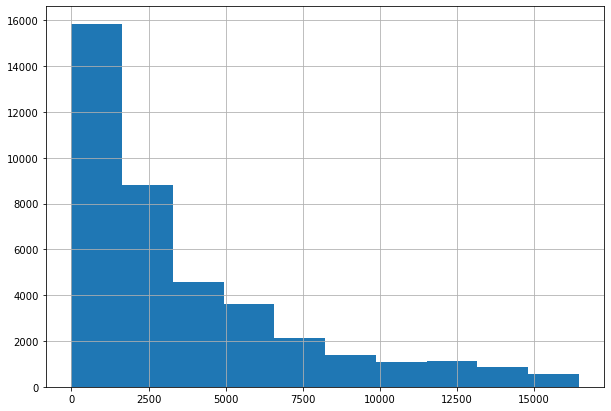

In [49]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=10)

Ranking seems biased

<AxesSubplot:>

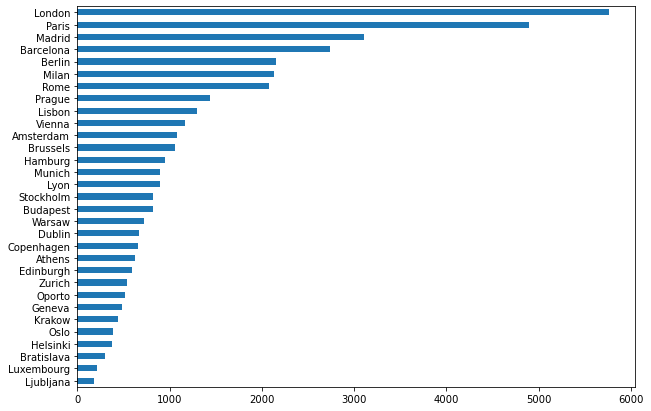

In [50]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Let us check the  city with the biggest number of restaurants

<AxesSubplot:>

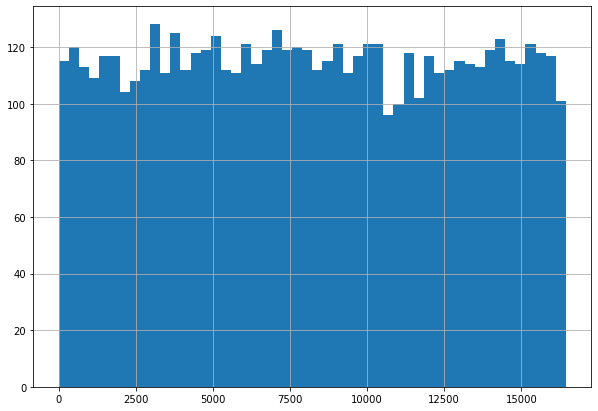

In [51]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=50)

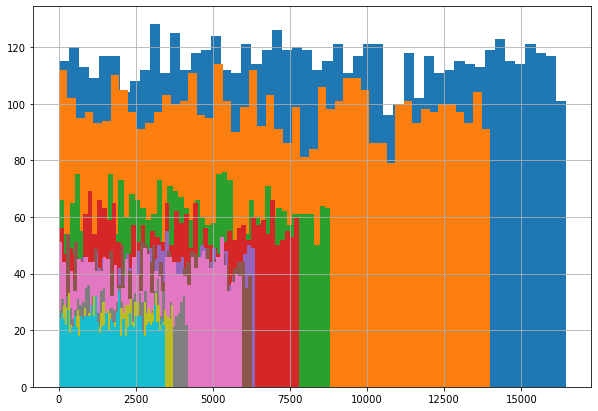

In [52]:
# for top cities
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=50)
plt.show()

Thus, we can see that the data is biased due to the fact that big cities have more restaurants. We need to normalize the feature.

In [53]:
# creating temp dataframe with number of restaurants per city (based on given data)
restaurants_per_city = (pd.DataFrame(df_train['City'].value_counts()))
restaurants_per_city.columns = ['Number of restaurants']
restaurants_per_city['City'] = restaurants_per_city.index

In [54]:
# merging dataframes on City: now we have 'Number of restaurants' column
df_train = pd.DataFrame.merge(df_train,restaurants_per_city,on='City')
df_train.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Number of restaurants
10212,id_5968,London,"['Italian', 'Pizza', 'Vegetarian Friendly', 'G...",5977.0,3.5,$$ - $$$,103.0,"[['Not bad, better than Zizzi & Carluccio!', '...",/Restaurant_Review-g186338-d734345-Reviews-ASK...,d734345,1,5757
18978,id_276,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",277.0,4.0,$$ - $$$,444.0,"[['Lunch near the Vatican', 'Close to the Vati...",/Restaurant_Review-g187791-d1910903-Reviews-Os...,d1910903,1,2078
8373,id_5813,London,"['British', 'Gluten Free Options', 'Vegetarian...",5822.0,4.5,$$ - $$$,73.0,"[['Nice food and service', 'Breakfast'], ['10/...",/Restaurant_Review-g186338-d3628752-Reviews-Bo...,d3628752,1,5757


Normalized Ranking (divided by number of restaurants) shows the same distribution as we have per each city.

<AxesSubplot:>

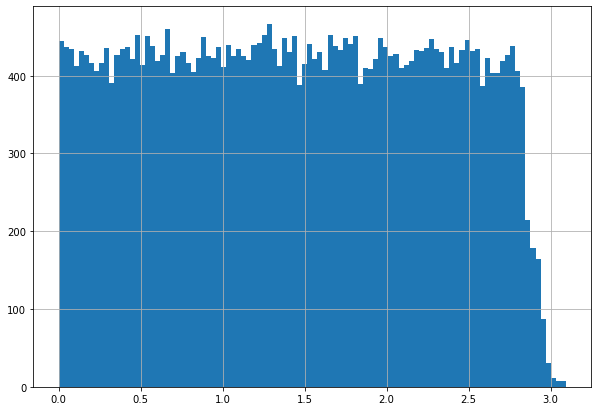

In [55]:
df_train['Ranking Normalized'] = df_train['Ranking'] / df_train['Number of restaurants']
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking Normalized'].hist(bins=100)

### Time between reviews


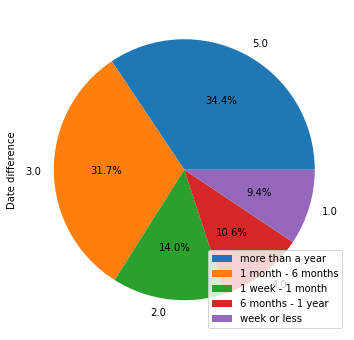

In [56]:
pie_list = list(data['Date difference'].value_counts().index) # to keep the order
list(map(pie_legend, pie_list))

# creating the chart itself
plt.figure(figsize=(8,5))
data['Date difference'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,6))
plt.legend(list(map(pie_legend, pie_list)), loc="lower right")

### Target Value Distribution
Rating has almost normal distribution; it is negatively-skewed, with its single peak at 4, which seems to be usual for a rating. 

<AxesSubplot:>

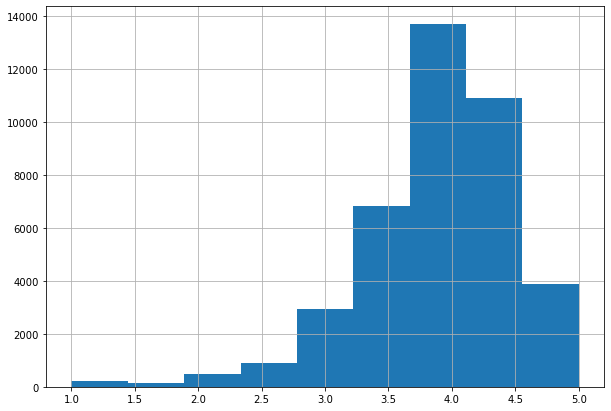

In [57]:
df_train['Rating'].hist(bins=9)

### Correlation
Since there is only one numeric variable, we will check correlation only with it

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Restaurant_id                  50000 non-null  object 
 1   City                           50000 non-null  object 
 2   Cuisine Style                  50000 non-null  object 
 3   Ranking                        50000 non-null  float64
 4   Price Range                    50000 non-null  float64
 5   Number of Reviews              50000 non-null  float64
 6   Reviews                        50000 non-null  object 
 7   URL_TA                         50000 non-null  object 
 8   ID_TA                          50000 non-null  object 
 9   sample                         50000 non-null  int64  
 10  Rating                         50000 non-null  float64
 11  No Reviews                     50000 non-null  bool   
 12  Chain                          50000 non-null 

<AxesSubplot:>

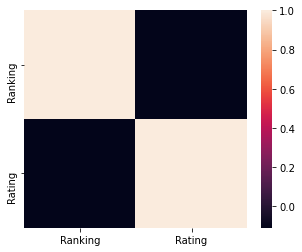

In [59]:
plt.rcParams['figure.figsize'] = (5,4)
sns.heatmap(data[['Ranking', 'Rating']].corr(),)

### Categorial variables which affect predicted value

In [60]:
df_train = data[data['sample'] == 1]

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 10000 to 49999
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Restaurant_id                  40000 non-null  object 
 1   City                           40000 non-null  object 
 2   Cuisine Style                  40000 non-null  object 
 3   Ranking                        40000 non-null  float64
 4   Price Range                    40000 non-null  float64
 5   Number of Reviews              40000 non-null  float64
 6   Reviews                        40000 non-null  object 
 7   URL_TA                         40000 non-null  object 
 8   ID_TA                          40000 non-null  object 
 9   sample                         40000 non-null  int64  
 10  Rating                         40000 non-null  float64
 11  No Reviews                     40000 non-null  bool   
 12  Chain                          40000 non-n

In [62]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x=column, y='Rating',
                data=df_train.loc[df_train.loc[:, column].isin(
                    df_train.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

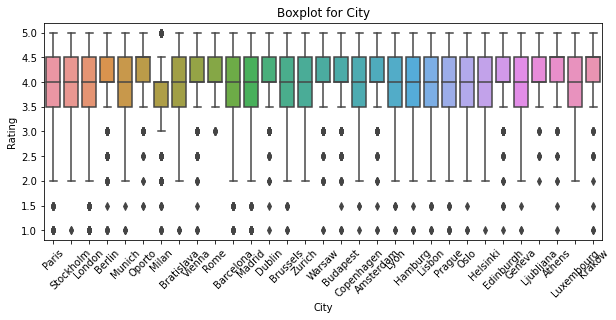

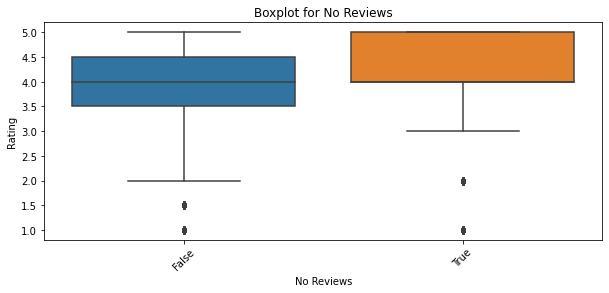

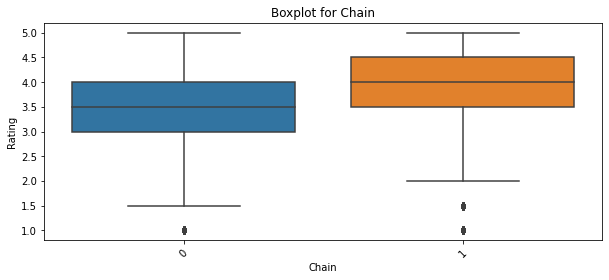

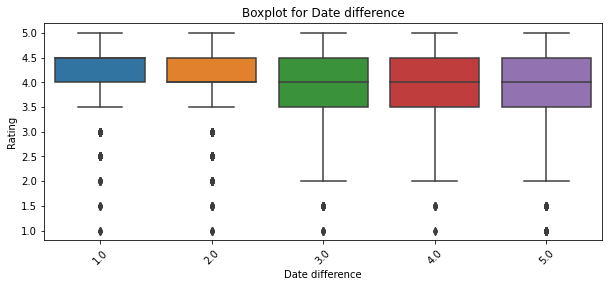

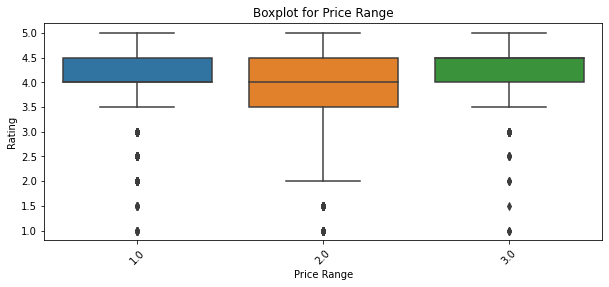

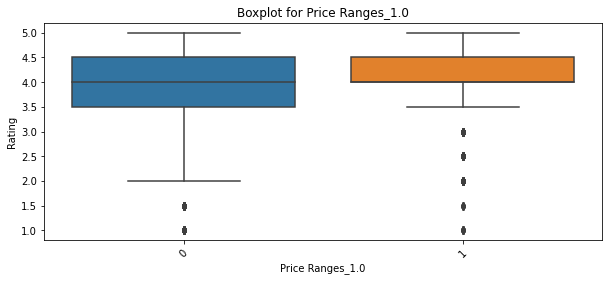

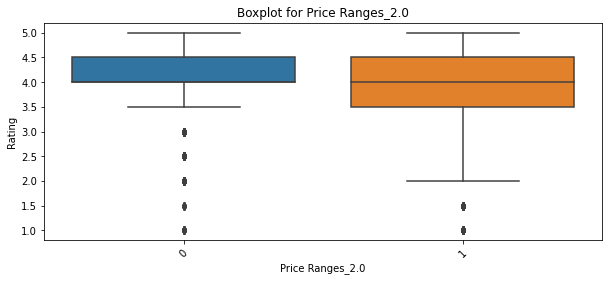

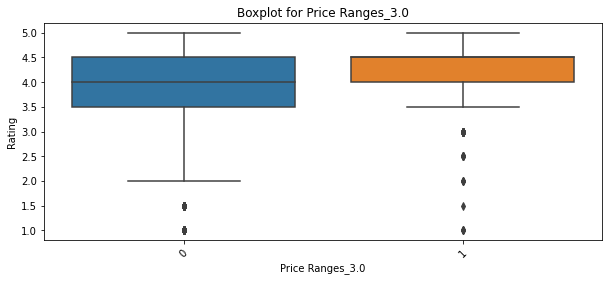

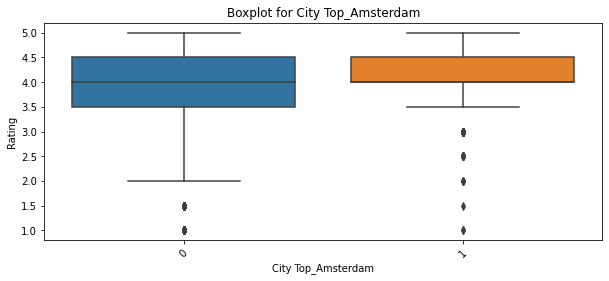

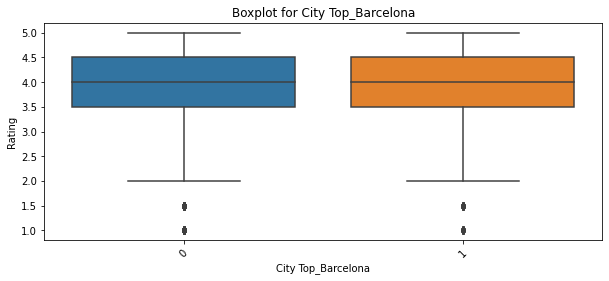

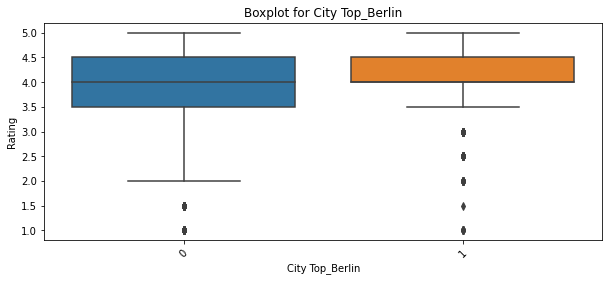

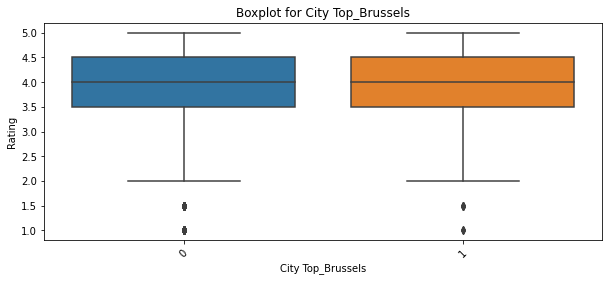

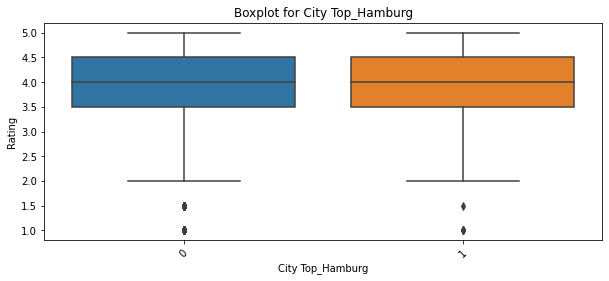

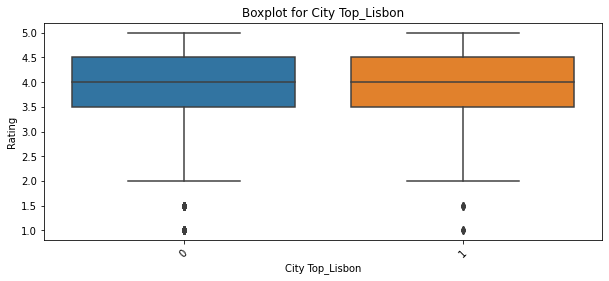

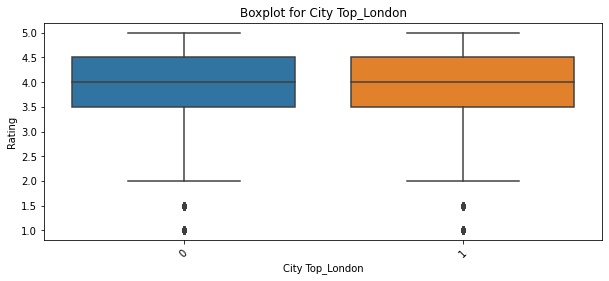

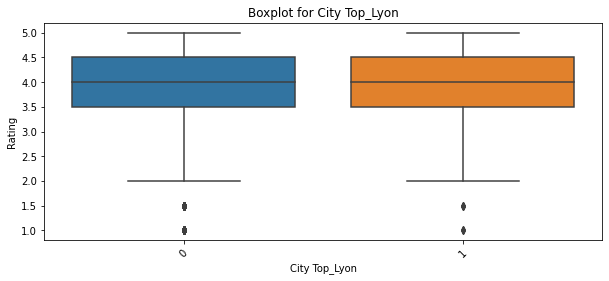

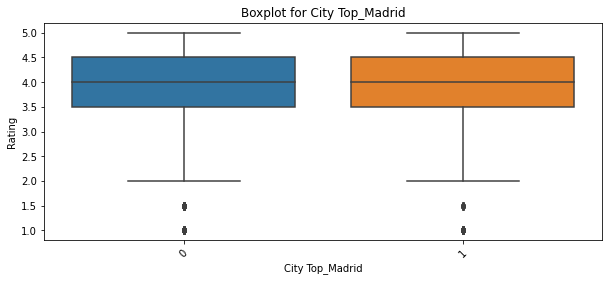

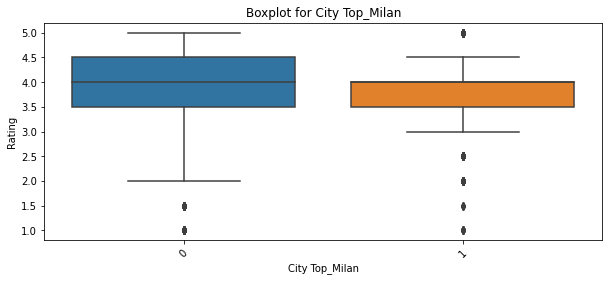

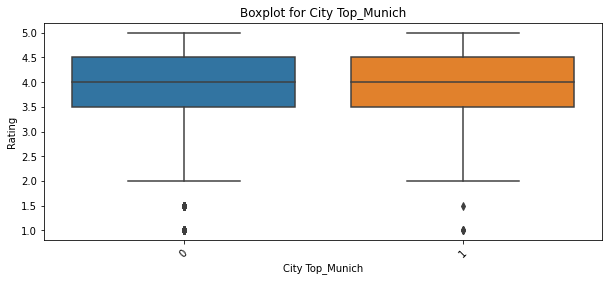

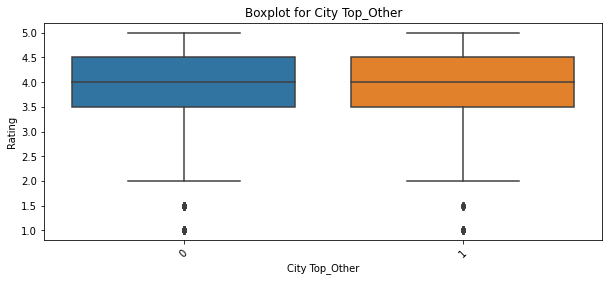

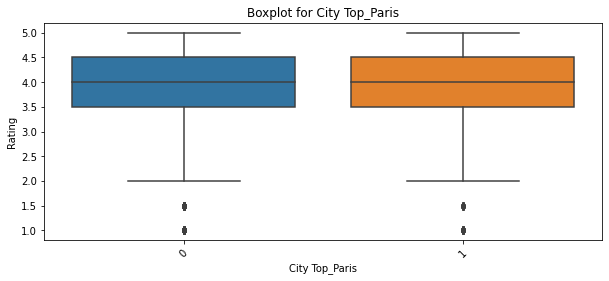

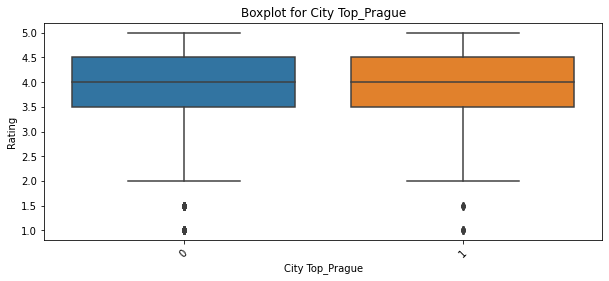

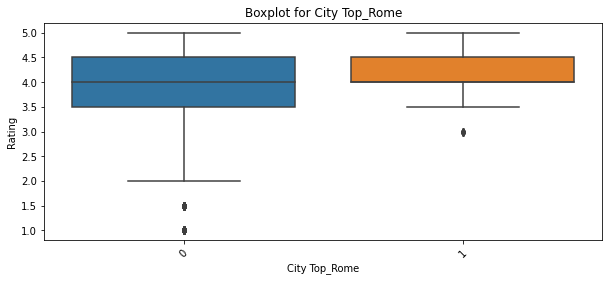

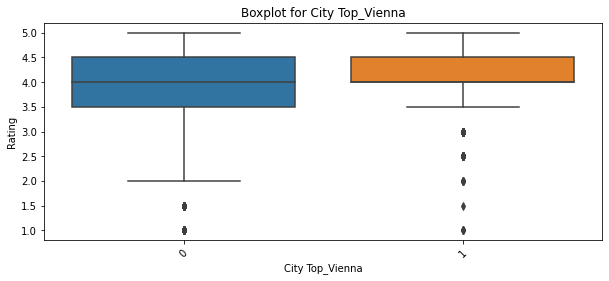

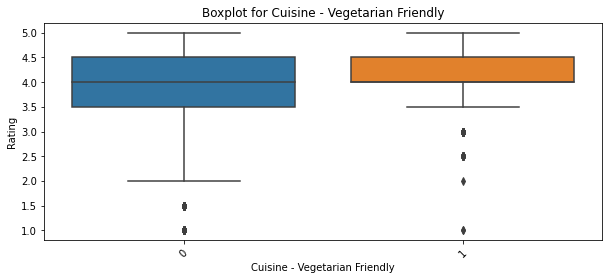

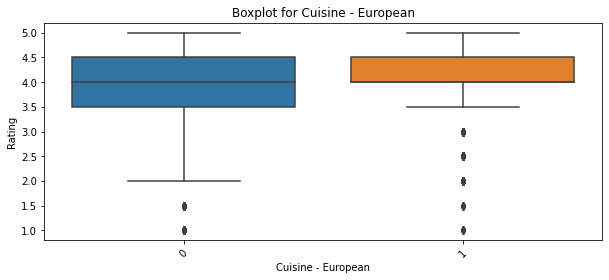

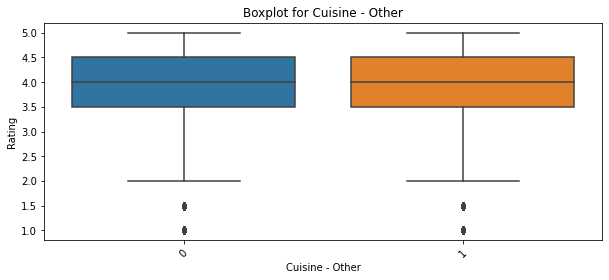

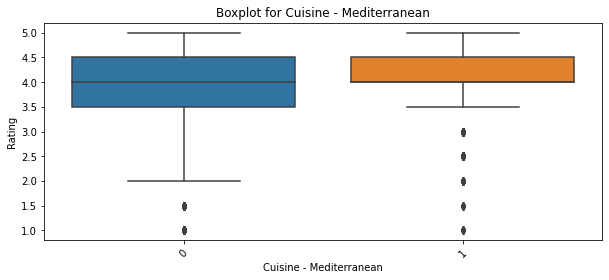

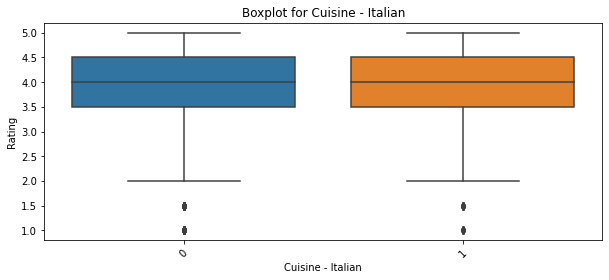

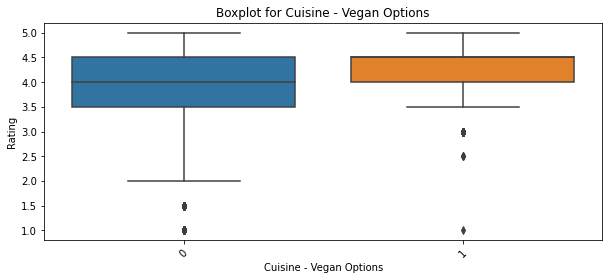

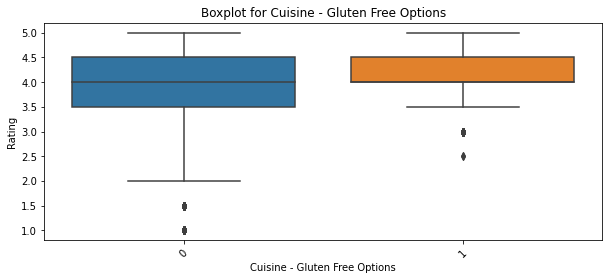

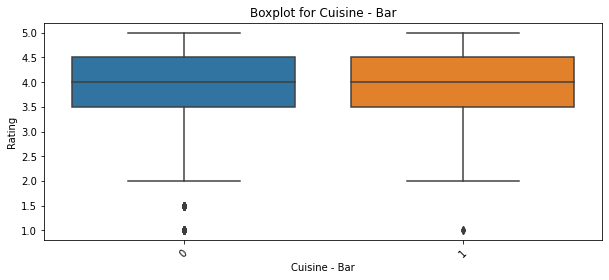

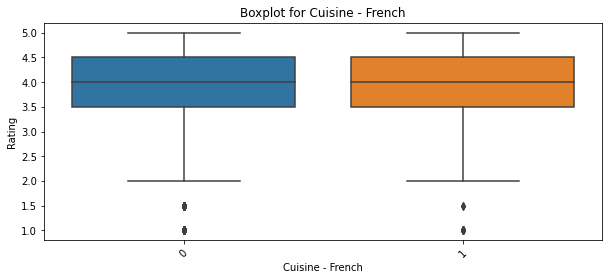

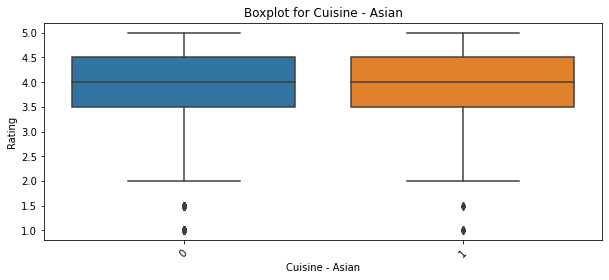

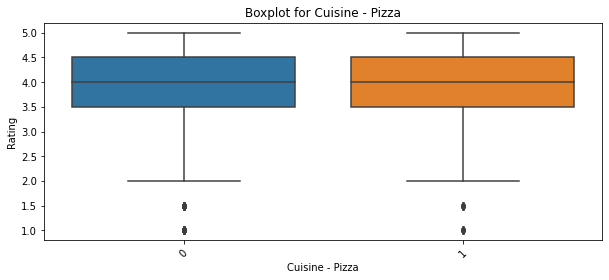

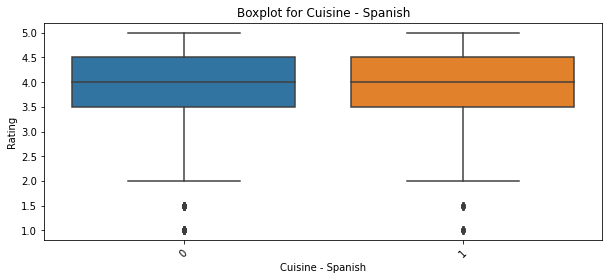

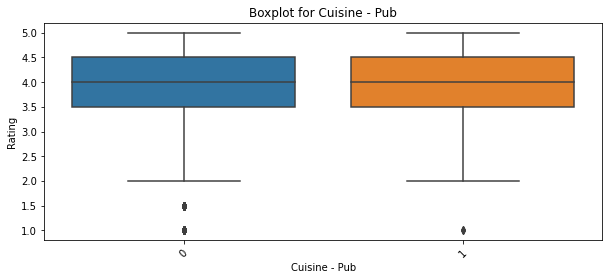

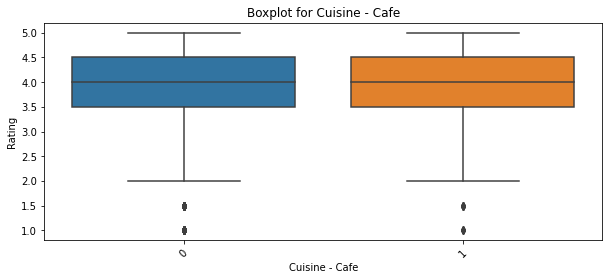

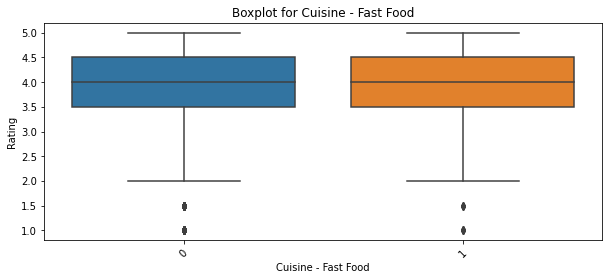

In [63]:
for col in ['City', 'No Reviews', 'Chain', 'Date difference','Price Range', 'Price Ranges_1.0',
            'Price Ranges_2.0', 'Price Ranges_3.0', 'City Top_Amsterdam', 'City Top_Barcelona', 'City Top_Berlin',
           'City Top_Brussels', 'City Top_Hamburg', 'City Top_Lisbon', 'City Top_London', 'City Top_Lyon', 
           'City Top_Madrid', 'City Top_Milan', 'City Top_Munich', 'City Top_Other', 'City Top_Paris',
           'City Top_Prague', 'City Top_Rome', 'City Top_Vienna', 'Cuisine - Vegetarian Friendly','Cuisine - European',
            'Cuisine - Other', 'Cuisine - Mediterranean', 'Cuisine - Italian', 'Cuisine - Vegan Options',
           'Cuisine - Gluten Free Options', 'Cuisine - Bar', 'Cuisine - French', 'Cuisine - Asian',
           'Cuisine - Pizza', 'Cuisine - Spanish', 'Cuisine - Pub', 'Cuisine - Cafe', 'Cuisine - Fast Food']:
    get_boxplot(col)

Cat variables affecting target:
'City', 'No Reviews', 'Chain', 'Date difference','Price Range', 'Price Ranges_1.0', 'Price Ranges_2.0', 'Price Ranges_3.0',  'City Top_Amsterdam', 'City Top_Berlin',  'City Top_Milan',  'City Top_Rome', 'City Top_Vienna', 'Cuisine - Vegetarian Friendly','Cuisine - European','Cuisine - Mediterranean', 'Cuisine - Vegan Options','Cuisine - Gluten Free Options', 
 
 
Cat variables not affecting target much:
'City Top_Brussels','City Top_Barcelona', ,'City Top_Hamburg', 'City Top_Lisbon', 'City Top_London', 'City Top_Lyon', 'City Top_Madrid','City Top_Munich', 'City Top_Other', 'City Top_Paris', 'City Top_Prague', 'Cuisine - Other', 'Cuisine - Italian', 'Cuisine - Bar','Cuisine - French', 'Cuisine - Asian', 'Cuisine - Pizza', 'Cuisine - Spanish', 'Cuisine - Pub', 'Cuisine - Cafe', 'Cuisine - Fast Food'

In [64]:
def get_stat_dif(column):
    cols = df_train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'Rating'],
                     df_train.loc[df_train.loc[:, column] == comb[1], 'Rating']).pvalue \
                <= 0.05/len(combinations_all):
            print('Statistically significant difference is found for the column', column)
            break

In [65]:
for col in ['City','No Reviews', 'Chain', 'Date difference','Price Range', 'Price Ranges_1.0',
            'Price Ranges_2.0', 'Price Ranges_3.0', 'City Top_Amsterdam', 'City Top_Barcelona', 'City Top_Berlin',
           'City Top_Brussels', 'City Top_Hamburg', 'City Top_Lisbon', 'City Top_London', 'City Top_Lyon', 
           'City Top_Madrid', 'City Top_Milan', 'City Top_Munich', 'City Top_Other', 'City Top_Paris',
           'City Top_Prague', 'City Top_Rome', 'City Top_Vienna', 'Cuisine - Vegetarian Friendly','Cuisine - European',
            'Cuisine - Other', 'Cuisine - Mediterranean', 'Cuisine - Italian', 'Cuisine - Vegan Options',
           'Cuisine - Gluten Free Options', 'Cuisine - Bar', 'Cuisine - French', 'Cuisine - Asian',
           'Cuisine - Pizza', 'Cuisine - Spanish', 'Cuisine - Pub', 'Cuisine - Cafe', 'Cuisine - Fast Food']:
    get_stat_dif(col)

Statistically significant difference is found for the column City
Statistically significant difference is found for the column Chain
Statistically significant difference is found for the column Date difference
Statistically significant difference is found for the column Price Range
Statistically significant difference is found for the column Price Ranges_1.0
Statistically significant difference is found for the column Price Ranges_2.0
Statistically significant difference is found for the column Price Ranges_3.0
Statistically significant difference is found for the column City Top_Amsterdam
Statistically significant difference is found for the column City Top_Barcelona
Statistically significant difference is found for the column City Top_Berlin
Statistically significant difference is found for the column City Top_Brussels
Statistically significant difference is found for the column City Top_Lisbon
Statistically significant difference is found for the column City Top_London
Statistically

affect:

'City', 'Chain', 'Date difference','Price Range', 'Price Ranges_1.0','Price Ranges_2.0', 'Price Ranges_3.0','City Top_Amsterdam', 'City Top_Barcelona', 'City Top_Berlin','City Top_Brussels','City Top_Lisbon', 'City Top_London',   'City Top_Madrid', 'City Top_Milan', 'City Top_Munich', 'City Top_Other', 'City Top_Paris','City Top_Prague','City Top_Rome', 'City Top_Vienna', 'Cuisine - Vegetarian Friendly','Cuisine - European','Cuisine - Other', 'Cuisine - Mediterranean', 'Cuisine - Italian', 'Cuisine - Vegan Options','Cuisine - Gluten Free Options',  'Cuisine - Bar', 'Cuisine - French','Cuisine - Pizza', 'Cuisine - Spanish','Cuisine - Cafe, 'Cuisine - Fast Food'
           
do not affect:

'No Reviews',  'City Top_Hamburg',  'City Top_Lyon',    , 'Cuisine - Bar', 'Cuisine - French', 'Cuisine - Asian', 'Cuisine - Pub',  





### Conclusion

* Most columns have no missing values, however there are still 4 columns where values are missing, for some of them it is 1/3 of the dataset (Cuisine Style - 23%,Price Range - 35%, Number of Reviews    6%, Reviews - 16%). Since 2/3 or more of cells in these columns have data, all columns were kept.
* There is a strong positive correlation between Ranking and Rating, which is obvious and expected.
* Per graphic representation, most important information is that pertaining to city, price range, specific menu. Interesting observation is that, on one hand, healthy options are valued (such as vegan/vegeterian/gluten free), on the other hand, pizza and fast food on the menu are also impotant to customers. 
* Variables proposed to be used in futher analysis: 'Ranking', 'City', 'Chain', 'Date difference','Price Range', 'Price Ranges_1.0','Price Ranges_2.0', 'Price Ranges_3.0','City Top_Amsterdam', 'City Top_Barcelona', 'City Top_Berlin','City Top_Brussels','City Top_Lisbon', 'City Top_London', 'City Top_Madrid', 'City Top_Milan', 'City Top_Munich', 'City Top_Other', 'City Top_Paris','City Top_Prague','City Top_Rome', 'City Top_Vienna', 'Cuisine - Vegetarian Friendly','Cuisine - European','Cuisine - Other', 'Cuisine - Mediterranean', 'Cuisine - Italian', 'Cuisine - Vegan Options','Cuisine - Gluten Free Options', 'Cuisine - Bar', 'Cuisine - French','Cuisine - Pizza', 'Cuisine - Spanish','Cuisine - Cafe, 'Cuisine - Fast Food'

# Data Preprocessing
Let us make it one big function

In [67]:
# uploading data again
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['Rating'] = 0 

data = df_test.append(df_train, sort=False).reset_index(drop=True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [68]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    ########## PREPROCESSING ##########
    
    ### FUNCTIONS ###
    
    # cuisine column update 
    def cuisine_to_list(cell):
        if type(cell) == str:
            cell = cell[1:-1].replace("'", "").split(', ')
            return cell

    # labelling price ranges
    def price_to_label(cell):
        if type(cell) == str:
            if cell == '$':
                return 1
            if cell == '$$ - $$$':
                return 2
            if cell == '$$$$':

                return 3

    # updating reviews column to tuples
    def format_reviews(cell):
        if type(cell) == str:
            if cell == '[[], []]':
                cell = nan  # we will look at NaN values further
            else:
                cell = eval(cell.replace("], [", ", ").replace(
                    "[[", '').replace("]]", ''))
            return cell

    # filling in NAN cells in number of reviews
    def fill_number_review(x):
        if (pd.isna(x['Number of Reviews'])) and (pd.notna(x['Reviews'])):
            if len(x['Reviews']) == 2:  # i.e. only one text and one date
                return 1
            else:
                return median_number_reviews
        if (pd.isna(x['Number of Reviews'])) and (pd.isna(x['Reviews'])):
            return 0
        return x['Number of Reviews'] 

    # defining other city
    def other_city(cell):
        if cell not in top_15_cities:
            cell = 'Other'
        return cell

    # using reviews column to create columns with texts and dates
    def review_text(cell):
        if cell == 'Not Available':
            return cell
        if len(cell) == 2:
            return cell[0]
        if len(cell) == 4:
            return list(cell[:2])

    def review_date1(cell):
        if cell == 'Not Available' or len(cell) == 2:
            return pd.to_datetime(np.nan)
        if len(cell) == 4:
            return pd.to_datetime(cell[2]).date()

    def review_date2(cell):
        if cell == 'Not Available':
            return pd.to_datetime(np.nan)
        if len(cell) == 2:
            return pd.to_datetime(cell[1]).date()
        if len(cell) == 4:
            return pd.to_datetime(cell[3]).date()

    # labelling time periods
    def date_diff_label(days):
        if days <= 7:
            return 1
        if 7 < days <= 30:
            return 2
        if 30 < days <= 180:
            return 3
        if 180 < days <= 365:
            return 4
        if days > 365:
            return 5

    # defining top cuisine styles
    def top_cuisine(cell):
        new_cuisine_list = []
        if cell == 'Other':
            new_cuisine_list.append(cell)
        for cuisine in cell:
            if cuisine in top_15_cuisines:
                new_cuisine_list.append(cuisine)
        return new_cuisine_list

    # labelling cuisine styles (for new feature)
    def vegetarian_friendly(cell):
        if 'Vegetarian Friendly' in cell:
            return 1
        else:
            return 0

    def european(cell):
        if 'European' in cell:
            return 1
        else:
            return 0

    def other(cell):
        if 'Other' in cell:
            return 1
        else:
            return 0

    def mediterranean(cell):
        if 'Mediterranean' in cell:
            return 1
        else:
            return 0

    def italian(cell):
        if 'Italian' in cell:
            return 1
        else:
            return 0

    def vegan_options(cell):
        if 'Vegan Options' in cell:
            return 1
        else:
            return 0

    def gluten_free(cell):
        if 'Gluten Free Options' in cell:
            return 1
        else:
            return 0

    def bar(cell):
        if 'Bar' in cell:
            return 1
        else:
            return 0

    def french(cell):
        if 'French' in cell:
            return 1
        else:
            return 0

    def asian(cell):
        if 'Asian' in cell:
            return 1
        else:
            return 0

    def pizza(cell):
        if 'Pizza' in cell:
            return 1
        else:
            return 0

    def spanish(cell):
        if 'Spanish' in cell:
            return 1
        else:
            return 0

    def pub(cell):
        if 'Pub' in cell:
            return 1
        else:
            return 0

    def cafe(cell):
        if 'Cafe' in cell:
            return 1
        else:
            return 0

    def fast_food(cell):
        if 'Fast Food' in cell:
            return 1
        else:
            return 0

    # creating legend list for our pie chat
    def pie_legend(x):
        if x == 1:
            return 'week or less'
        if x == 2:
            return '1 week - 1 month'
        if x == 3:
            return '1 month - 6 months'
        if x == 4:
            return '6 months - 1 year'
        if x == 5:
            return 'more than a year'
    
    
    
    ###### Cleaning and Prepping Data ######
    
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: cuisine_to_list(x))
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: price_to_label(x))
    df_output['Reviews'] = df_output['Reviews'].apply(lambda x: format_reviews(x))
    
    
    
    
    ###### NAN ###### 
        
    df_output['No Reviews'] = df_output['Number of Reviews'].isna()
    df_output['Cuisine Style'].fillna('Other', inplace=True)
    df_output['Price Range'].fillna(2, inplace=True)
    
    df_output['Number of Reviews'] = df_output.apply(fill_number_review, axis = 1)
    df_output['Reviews'].fillna('Not Available', inplace=True)
     
    
    ###### NEW FEATURES ######
    chain_id = list(df_output['Restaurant_id'].value_counts()[df_output['Restaurant_id'].value_counts()>1].index)
    df_output['Chain'] = (df_output.apply((lambda x: 1 if x['Restaurant_id'] in chain_id else 0), axis = 1))
    
    top_15_cities = df_output['City'].value_counts().index[:15]
    df_output['City Top'] = df_output['City'].apply(lambda x: other_city(x))
    df_output = pd.get_dummies(df_output, columns=['City Top'])
    
    df_output['Review Texts'] = df_output['Reviews'].apply(lambda x: review_text(x))
    df_output['Date of 1st Review'] = df_output['Reviews'].apply(lambda x: review_date1(x))
    df_output['Date of 2nd Review'] = df_output['Reviews'].apply(lambda x: review_date2(x))

    df_output['Date difference'] = (abs(df_output['Date of 1st Review'] - df_output['Date of 2nd Review']
                               ).dt.days).apply(lambda x: date_diff_label(x)).fillna(5)
    
    df_output['Price Ranges'] = df_output['Price Range']
    df_output = pd.get_dummies(df_output, columns=['Price Ranges'])
           
    
    top_15_cuisines = list(df_output.explode('Cuisine Style')['Cuisine Style'].value_counts().index[:15])
    df_output['Top Cuisine'] = df_output['Cuisine Style'].apply(lambda x: top_cuisine(x))
    df_output['Cuisine - Vegetarian Friendly'] = df_output['Top Cuisine'].apply(lambda x: vegetarian_friendly(x))
    df_output['Cuisine - European'] = df_output['Top Cuisine'].apply(lambda x: european(x))
    df_output['Cuisine - Other'] = df_output['Top Cuisine'].apply(lambda x: other(x))
    df_output['Cuisine - Mediterranean'] = df_output['Top Cuisine'].apply(lambda x: mediterranean(x))
    df_output['Cuisine - Italian'] = df_output['Top Cuisine'].apply(lambda x: italian(x))
    df_output['Cuisine - Vegan Options'] = df_output['Top Cuisine'].apply(lambda x: vegan_options(x))
    df_output['Cuisine - Gluten Free Options'] = df_output['Top Cuisine'].apply(lambda x: gluten_free(x))
    df_output['Cuisine - Bar'] = df_output['Top Cuisine'].apply(lambda x: bar(x))
    df_output['Cuisine - French'] = df_output['Top Cuisine'].apply(lambda x: french(x))
    df_output['Cuisine - Asian'] = df_output['Top Cuisine'].apply(lambda x: asian(x))
    df_output['Cuisine - Pizza'] = df_output['Top Cuisine'].apply(lambda x: pizza(x))
    df_output['Cuisine - Spanish'] = df_output['Top Cuisine'].apply(lambda x: spanish(x))
    df_output['Cuisine - Pub'] = df_output['Top Cuisine'].apply(lambda x: pub(x))
    df_output['Cuisine - Cafe'] = df_output['Top Cuisine'].apply(lambda x: cafe(x))
    df_output['Cuisine - Fast Food'] = df_output['Top Cuisine'].apply(lambda x: fast_food(x))
    

    

    # ################### 5. Clean #################################################### 
    
    df_output.drop(['Restaurant_id','ID_TA',  'No Reviews',  'City Top_Hamburg',  'City Top_Lyon',
                    'Cuisine - Bar', 'Cuisine - French', 'Cuisine - Asian', 'Cuisine - Pub'
                   ], axis = 1, inplace=True)
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

In [69]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Chain,City Top_Amsterdam,City Top_Barcelona,City Top_Berlin,City Top_Brussels,...,Cuisine - European,Cuisine - Other,Cuisine - Mediterranean,Cuisine - Italian,Cuisine - Vegan Options,Cuisine - Gluten Free Options,Cuisine - Pizza,Cuisine - Spanish,Cuisine - Cafe,Cuisine - Fast Food
48881,7639.0,2.0,238.0,1,3.5,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
17421,2090.0,1.0,6.0,1,3.5,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
41442,5459.0,2.0,8.0,1,4.5,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28777,5370.0,2.0,710.0,1,3.0,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
3628,2258.0,2.0,6.0,0,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2495,14435.0,2.0,8.0,0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44828,1011.0,2.0,38.0,1,4.5,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
21691,5357.0,2.0,15.0,1,3.5,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
34890,7220.0,1.0,4.0,1,4.5,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
25102,2564.0,2.0,5.0,1,4.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [70]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ranking                        50000 non-null  float64
 1   Price Range                    50000 non-null  float64
 2   Number of Reviews              50000 non-null  float64
 3   sample                         50000 non-null  int64  
 4   Rating                         50000 non-null  float64
 5   Chain                          50000 non-null  int64  
 6   City Top_Amsterdam             50000 non-null  uint8  
 7   City Top_Barcelona             50000 non-null  uint8  
 8   City Top_Berlin                50000 non-null  uint8  
 9   City Top_Brussels              50000 non-null  uint8  
 10  City Top_Lisbon                50000 non-null  uint8  
 11  City Top_London                50000 non-null  uint8  
 12  City Top_Madrid                50000 non-null 

In [71]:
# test part
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values           
X = train_data.drop(['Rating'], axis=1)

**Validation**

In [72]:
# 20% for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [73]:
# checking
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 34), (40000, 34), (40000, 33), (32000, 33), (8000, 33))

# Model 
ML itself

In [74]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

In [75]:
# creating the model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [76]:
# training on test 
model.fit(X_train, y_train)

# forecasting
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [77]:
# Mean Absolute Error (MAE), a statistical measure of how accurate a forecast system is
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2391148125


<AxesSubplot:>

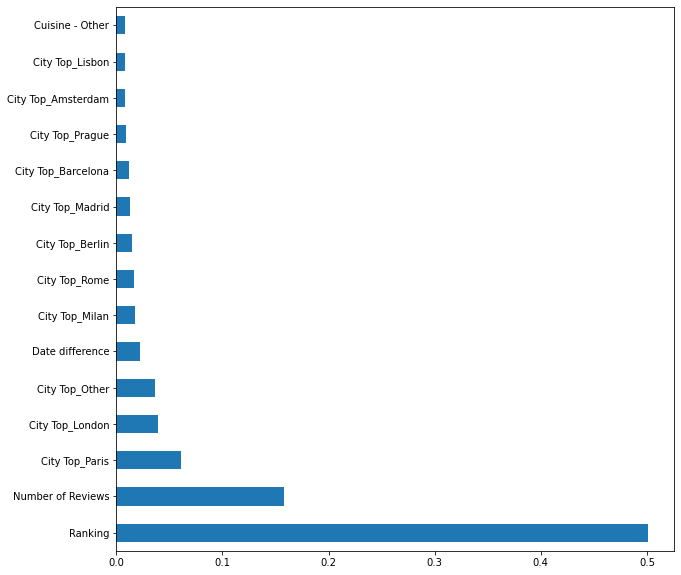

In [78]:
# RandomForestRegressor - most important features
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission


In [79]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Chain,City Top_Amsterdam,City Top_Barcelona,City Top_Berlin,City Top_Brussels,City Top_Lisbon,...,Cuisine - European,Cuisine - Other,Cuisine - Mediterranean,Cuisine - Italian,Cuisine - Vegan Options,Cuisine - Gluten Free Options,Cuisine - Pizza,Cuisine - Spanish,Cuisine - Cafe,Cuisine - Fast Food
3719,4539.0,2.0,114.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2808,827.0,1.0,110.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3978,807.0,2.0,3.0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2512,5032.0,2.0,32.0,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3575,9839.0,2.0,73.0,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2967,829.0,2.0,226.0,0.0,1,0,0,0,0,0,...,1,0,0,1,1,1,1,0,0,0
8967,4745.0,2.0,85.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2182,966.0,2.0,213.0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5593,7644.0,2.0,42.0,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
526,8307.0,2.0,24.0,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [80]:
test_data = test_data.drop(['Rating'], axis=1)

In [81]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [82]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [83]:
predict_submission

array([2.975, 4.395, 3.885, ..., 3.015, 4.5  , 4.28 ])

In [84]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.975
1,id_1,4.395
2,id_2,3.885
3,id_3,4.380
4,id_4,4.470
5,id_5,4.385
6,id_6,2.295
7,id_7,2.755
8,id_8,4.680
9,id_9,4.255
